## Using this notebook

The underlying data is avaialble by clicking 'download' at the following page. 
https://www.globalforestwatch.org/dashboards/global/

After downloading, we opened the tab in a spreadsheet software (Google Sheets) and download the tab 'Subnational 1 tree cover loss" and this file is saved as 'hansen.csv' for use in calculations below

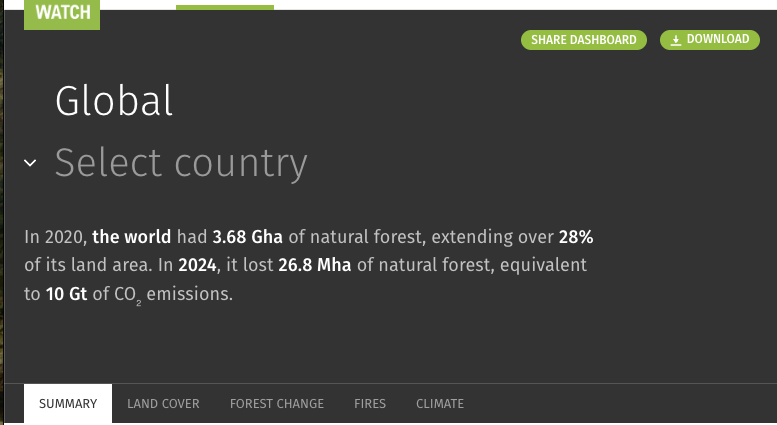

## Finding Discrepancies Between Hansen Forest Loss and Covariate Tables

The Hansen forest loss data and covariates (pop. density, elevation, slope etc.) were found to be misaligned for some countries' jurisdictions.

This was occuring where:

1. The Hansen/covariate tables used different levels of administration. For example, the covariate table had rows for most towns/cities/counties within the United Kingdom (e.g. Cornwall, Carmarthenshire, Coleraine etc.) where as Hansen only gave forest loss data for each constituent nation (England, Wales, Scotland, N. Ireland).
2. Autonomous regions or overseas territories were listed as their own countries in one tables, but then as a jurisdiction of their parent nation in another (e.g. Martinique in France).
3. Different names were used for the same region, or ASCI characters were used for regions whose names had accents.

To maximise the data that could be used for model training, these discrepancies were investigated and fixed. The following cell iterates throw each row of the tables to assess which countries exhibit these differences.

In [1]:
# Import packages
import os
import numpy as np
import pandas as pd

# Define the input dir containing CSV files
input_dir = "/Users/rexdevereux/Desktop/Python/earth-data-hub/Data_FD/predicted-deforestation"

# Define the threshold to be applied
thresh = 10

# Read in Hansen et al. (2013) Forest Loss Data
hansen_df = pd.read_csv(
    os.path.join(input_dir, "hansen.csv"), quotechar='"'
).sort_values(by=["country", "subnational1"])

# Apply threshold of X%
hansen_df = hansen_df.loc[hansen_df["threshold"] == thresh]

# Read in jurisdictions to feed to the model
regions_df = pd.read_csv(
    os.path.join(input_dir, "jurisdictions.csv"), quotechar='"'
).sort_values(by=["admin", "name"])

# Replace Hansen country names with those in the jurisdiction list
hansen_df = hansen_df.replace(
    to_replace=[
        "United States", "Serbia", "México", "Tanzania", "Guinea-Bissau", 
        "Côte d'Ivoire", "Czechia", "Timor-Leste", "South Sudan"
    ],
    value=[
        "United States of America", "Republic of Serbia", "Mexico", 
        "United Republic of Tanzania", "Guinea Bissau", "Ivory Coast", 
        "Czech Republic", "East Timor", "S. Sudan"
    ]
)

# Get the unique lists of Hansen and desired countries
unique_hansen_countries = sorted(list(set(hansen_df["country"])))
unique_true_countries = sorted(list(set(regions_df["admin"])))

# Check list of desired jurisdictions to see if the country is missing Hansen data
missing_countries = [country for country in unique_true_countries if country not in unique_hansen_countries]
print(f'{", ".join(missing_countries)} are not in the Hansen et al. (2013) dataset.\n')

# Remove the countries with no forest loss data
regions_df = regions_df.loc[~regions_df["admin"].isin([
    "Puerto Rico", "Jamaica", "Armenia", "Caribbean Netherlands", "Dominica", 
    "Macedonia", "Moldova", "Montenegro", "Saint Lucia", "Samoa", "Taiwan", 
    "The Bahamas", "Trinidad and Tobago"
])]

# --- NEW STEP: Drop NaN region names to avoid join() errors ---
regions_df = regions_df.dropna(subset=["name"])

# Find the countries whose regions mismatch
for country in unique_true_countries:
    regions = regions_df.loc[regions_df["admin"] == country]
    hansen_regions = hansen_df.loc[hansen_df["country"] == country]

    if len(regions["name"]) != len(hansen_regions["subnational1"]):
        print(f"{country}:")
        print(", ".join([
            str(region) for region in list(regions["name"]) 
            if region not in list(hansen_regions["subnational1"])
        ]), "in jurisdiction list, but not in Hansen data.")
        print(", ".join([
            str(hansen_region) for hansen_region in list(hansen_regions["subnational1"]) 
            if hansen_region not in list(regions["name"])
        ]), "in Hansen data, but not in jurisdiction list.")
        print("\n")


Armenia, Caribbean Netherlands, Dominica, Jamaica, Macedonia, Moldova, Montenegro, Puerto Rico, Saint Lucia, Samoa, Taiwan, The Bahamas, Trinidad and Tobago are not in the Hansen et al. (2013) dataset.

Albania:
Albania in jurisdiction list, but not in Hansen data.
Berat, Dibër, Durrës, Elbasan, Fier, Gjirokastër, Korçë, Kukës, Lezhë, Shkodër, Tiranë, Vlorë in Hansen data, but not in jurisdiction list.


Algeria:
Algeria in jurisdiction list, but not in Hansen data.
Adrar, Alger, Annaba, Aïn Defla, Aïn Témouchent, Batna, Biskra, Blida, Bordj Bou Arréridj, Bouira, Boumerdès, Béchar, Béjaïa, Chlef, Constantine, Djelfa, El Bayadh, El Oued, El Tarf, Ghardaïa, Guelma, Illizi, Jijel, Khenchela, Laghouat, M'Sila, Mascara, Mila, Mostaganem, Médéa, Naâma, Oran, Ouargla, Oum el Bouaghi, Relizane, Saïda, Sidi Bel Abbès, Skikda, Souk Ahras, Sétif, Tamanghasset, Tiaret, Tindouf, Tipaza, Tissemsilt, Tizi Ouzou, Tlemcen, Tébessa in Hansen data, but not in jurisdiction list.


Azerbaijan:
Azerbaijan i

## Calculating Deforestation Rates and Forest Loss

Using some of the renamed countries/jurisdictions from the previous cell, we can now calculate percentage deforestation rates and forest area losses. Based on these values, we add an additional column according to whether this jurisdiction would have HFLD (High Forest Low Deforestation) status using the ART Trees definition. This definition states that a jurisdiction should have an HFLD score of more that 0.5, where:

**HFLD Score** = **Defor. Score** + **Forest Score**

**Defor. Score** = 0.5% - Defor. rate (as a %)

**Forest Score** = **Forest Coverage** (as a %) - 50%

We do not make the distinction that a jurisdiction should have an HFLD score of over 0.5 for 5 consecutive years.

In [2]:
hansen_df

,country,subnational1,threshold,area_ha,extent_2000_ha,extent_2010_ha,gain_2000-2012_ha,tc_loss_ha_2001,tc_loss_ha_2002,tc_loss_ha_2003,...,tc_loss_ha_2015,tc_loss_ha_2016,tc_loss_ha_2017,tc_loss_ha_2018,tc_loss_ha_2019,tc_loss_ha_2020,tc_loss_ha_2021,tc_loss_ha_2022,tc_loss_ha_2023,tc_loss_ha_2024
1,Afghanistan,Badakhshan,10,4368996.0,10556,1763.0,403.0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
9,Afghanistan,Badghis,10,2058697.0,2504,86.0,51.0,5,2,1,...,0,0,0,0,0,0,0,0,0,0.0
17,Afghanistan,Baghlan,10,2112104.0,4541,86.0,273.0,1,1,0,...,0,0,0,0,0,0,0,0,0,2.0
25,Afghanistan,Balkh,10,1725362.0,469,5.0,598.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
33,Afghanistan,Bamyan,10,1417319.0,775,1.0,5.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22750,Zimbabwe,Matabeleland South,10,5410226.0,1297622,1441915.0,4737.0,250,498,273,...,240,244,459,112,172,140,384,321,375,209.0
22758,Zimbabwe,Midlands,10,4936272.0,2000574,2207976.0,18669.0,2488,3312,2157,...,3606,2905,9222,3414,2212,2358,4593,2602,2023,1833.0
273,Åland,Archipelago,10,46397.0,34325,33624.0,583.0,58,24,49,...,69,102,113,99,130,24,106,159,164,277.0
281,Åland,Countryside,10,102866.0,78621,80431.0,1991.0,338,252,164,...,500,575,626,520,2236,648,1248,1021,940,685.0


In [3]:
import numpy as np
import os
import pandas as pd

# Define the input dir containing CSV files
INPUT_DIR = "/Users/rexdevereux/Desktop/Python/earth-data-hub/Data_FD/predicted-deforestation"

# Hansen forest definition (% canopy cover) to use for forest definition
THRESH = 10

# Define the method for calculating the HFLD status
METHOD = "ART"

# Calculate the HFLD score using the ART methodology
def ART_HFLD(for_area, pc_losses):
    # Calculate the forest cover score
    forest_score = (for_area - 50) / 100
    # Calculate the deforestation score
    defor_score = 0.5 - pc_losses
    # Calculate the High Forest Low Deforestation score
    HFLD_score = forest_score + defor_score
    return HFLD_score

def main(input_dir, thresh, method):
    # Read in the Hansen et al. (2013) data (expects hansen_df, regions_df to be defined in memory)
    hansen_data = hansen_df.to_numpy()

    # Extract columns into separate arrays for readability
    countries       = hansen_data[:, 0]                # Country names
    hansen_regions  = hansen_data[:, 1]                # Subnational region names (ADM1)
    area            = hansen_data[:, 3].astype(float)  # Land area (ha)
    extent_2000     = hansen_data[:, 4].astype(float)  # Tree cover extent in 2000 (ha)
    losses          = hansen_data[:, 7:].astype(float) # Annual tree cover loss (ha/year, cols 2001+)

    # Get the total loss each year since 2000
    total_loss = np.cumsum(losses, axis=1)

    # Create forest extent for each year
    extent_2000 = np.reshape(extent_2000, (extent_2000.size, -1))
    extent_per_year = extent_2000 - total_loss
    extent_per_year = np.concatenate((extent_2000, extent_per_year), axis=1)

    # Annual deforestation rate: loss / starting extent of that year (fraction)
    pc_losses = np.zeros(losses.shape)
    np.divide(losses, extent_per_year[:, :-1], out=pc_losses, where=extent_per_year[:, :-1] != 0)

    # Forest cover (fraction of land area) per year
    area = np.reshape(area, (area.size, -1))
    for_area = extent_per_year / area

    # % change in forest cover fraction (absolute YoY rate)
    pc_for_area = np.zeros(losses.shape)
    np.divide(np.abs(np.diff(for_area)), for_area[:, :-1], out=pc_for_area, where=for_area[:, :-1] != 0)

    # HFLD (ART)
    if method == "ART":
        HFLD_score  = ART_HFLD(100 * for_area[:, 1:], 100 * pc_losses)
        # HFLD when score EXCEEDS 0.5
        HFLD_status = np.where(HFLD_score > 0.5, 1, 0)
    else:
        raise NotImplementedError("Only ART methodology supported so far.")

    # Collect per-region/year rows
    region_data = []
    for i, reg in enumerate(hansen_regions):
        regions = regions_df.loc[regions_df["admin"] == countries[i]]
        if reg in list(regions["name"]):
            for year in range(0, 24):  # 2001..2024
                region_data.append((
                    countries[i],                 # country
                    reg,                          # region
                    2001 + year,                  # year
                    100 * for_area[i, year + 1],  # for_area (% of land area in forest)
                    100 * pc_for_area[i, year],   # pc_for_area (% change in forest cover fraction)
                    100 * pc_losses[i, year],     # deforRate (% forest lost that year)
                    HFLD_score[i, year],          # HFLD score
                    HFLD_status[i, year]          # HFLD simple (0/1)
                ))

    # ----- Build dataframe -----
    df = pd.DataFrame(region_data, columns=[
        "country", "region", "year",
        "for_area", "pc_for_area", "deforRate",
        "HFLD_score", "HFLD"
    ]).sort_values(["country", "region", "year"]).copy()

    # Trailing avg (uses whatever history exists, 1..5 yrs)
    grp_loss = df.groupby(["country", "region"], group_keys=False)["deforRate"]
    df["deforRate_5yr"] = (
        grp_loss.rolling(window=5, min_periods=1)
                .mean()
                .reset_index(level=[0,1], drop=True)
    )
    # Count of years used (1–5), handy for filtering later
    df["defor_yrs_used"] = (
        grp_loss.rolling(window=5, min_periods=1)
                .count()
                .reset_index(level=[0,1], drop=True)
                .astype(int)
    )

    # ----- Add HFLD_full_condition -----
    # For a 5-year streak, require ALL of the last 5 years' HFLD_score to be > 0.5
    grp_score = df.groupby(["country", "region"], group_keys=False)["HFLD_score"]
    rolling_min = (
        grp_score.rolling(window=5, min_periods=5)
                 .min()
                 .reset_index(level=[0,1], drop=True)
    )
    full_cond = (rolling_min > 0.5).astype(float)  # 1.0/0.0, NaN for first 4 years
    # Early years (no full 5-yr history): fall back to simple HFLD (no NaNs)
    df["HFLD_full_condition"] = full_cond.fillna(df["HFLD"]).astype(int)

    # ---- Join biome info from continents.csv (right key is 'admin') ----
    continents_path = os.path.join(input_dir, "continents.csv")
    cont_df = pd.read_csv(continents_path)

    # Normalize join keys
    df["country"] = df["country"].astype(str).str.strip()
    cont_df["admin"] = cont_df["admin"].astype(str).str.strip()

    # De-duplicate continents table by admin to avoid exploding rows on merge
    cont_df = cont_df.drop_duplicates(subset=["admin"])

    # Merge: left 'country' ↔ right 'admin'
    df = df.merge(
        cont_df[["admin", "biome"]],
        left_on="country",
        right_on="admin",
        how="left"
    )

    # Clean up: drop the helper 'admin' column from the merge and rename 'continent'
    df = df.drop(columns=["admin"])
    df = df.rename(columns={"continent": "continent_name"})

    # Save CSV (with biome + continent_name)
    out_csv = os.path.join(input_dir, f"defor_stats_{method}_with_biome.csv")
    df.to_csv(out_csv, index=False)
    print("Wrote:", out_csv)


if __name__ == "__main__":
    main(INPUT_DIR, THRESH, METHOD)


Wrote: /Users/rexdevereux/Desktop/Python/earth-data-hub/Data_FD/predicted-deforestation/defor_stats_ART_with_biome.csv
